# Import

In [158]:
import pandas as pd
from pandas import Series
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from datetime import date
from datetime import datetime, timedelta

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, PolynomialFeatures

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from catboost import CatBoostClassifier


from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, recall_score, f1_score, mean_absolute_error, mean_squared_error, precision_score

In [159]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [160]:
import warnings
warnings.filterwarnings("ignore")

In [161]:
# Зафиксируем RANDOM_SEED, чтобы эксперименты были воспроизводимы
RANDOM_SEED = 40

In [162]:
# Зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requiremnts.txt

# DATA

In [196]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [164]:
print(train.info())
train.sample(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
47681,62457,11MAR2014,SCH,M,40,N,N,0,0,-1.377348,2,60,1,3,55000,2,2,N,0
31906,1839,06JAN2014,GRD,F,46,Y,Y,0,0,-2.102748,3,60,1,2,45000,1,4,N,0
49655,16612,23JAN2014,GRD,F,36,N,N,0,0,-1.624690,8,60,2,3,5000,4,4,N,1


In [165]:
print(test.info())
test.sample(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   app_date          36349 non-null  object 
 2   education         36178 non-null  object 
 3   sex               36349 non-null  object 
 4   age               36349 non-null  int64  
 5   car               36349 non-null  object 
 6   car_type          36349 non-null  object 
 7   decline_app_cnt   36349 non-null  int64  
 8   good_work         36349 non-null  int64  
 9   score_bki         36349 non-null  float64
 10  bki_request_cnt   36349 non-null  int64  
 11  region_rating     36349 non-null  int64  
 12  home_address      36349 non-null  int64  
 13  work_address      36349 non-null  int64  
 14  income            36349 non-null  int64  
 15  sna               36349 non-null  int64  
 16  first_time        36349 non-null  int64 

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
5828,33230,09FEB2014,GRD,F,28,N,N,0,1,-2.291555,0,60,1,3,10000,1,4,N
30151,44385,20FEB2014,GRD,M,25,N,N,0,0,-1.672113,2,60,2,3,90000,1,3,N
826,21589,28JAN2014,SCH,F,47,N,N,0,0,-2.195642,0,50,1,1,22000,1,4,N


In [166]:
print(sample_submission.info())
sample_submission.sample(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24354 entries, 0 to 24353
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   client_id  24354 non-null  int64  
 1   default    24354 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 380.7 KB
None


,client_id,default
15019,63893,0.428311
17351,46995,0.062099
11870,45786,0.849688


In [197]:
# Для корректной обработки данных объединим train и test в один датасет
train['sample'] = 1 # помечаем train
test['sample'] = 0 # помечаем test
test['default'] = 0 # пока заполним нулями

data = test.append(train, sort=False).reset_index(drop=True)

In [168]:
print(data.info())
data.sample(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default
64846,50235,27FEB2014,GRD,M,36,N,N,0,0,-2.236634,2,70,1,2,65000,1,4,N,1,0
18339,35445,11FEB2014,UGR,F,29,N,N,0,0,-2.318781,4,40,2,3,40000,1,3,N,0,0
53497,61815,11MAR2014,UGR,F,24,N,N,0,1,-2.002983,2,60,1,2,25000,4,1,N,1,0


Описание полей датасета:

* client_id - идентификатор клиента
* education - уровень образования
* sex - пол заемщика
* age - возраст заемщика
* car - флаг наличия автомобиля
* car_type - флаг автомобиля иномарки
* decline_app_cnt - количество отказанных прошлых заявок
*  good_work - флаг наличия “хорошей” работы
* bki_request_cnt - количество запросов в БКИ
* home_address - категоризатор домашнего адреса
* work_address - категоризатор рабочего адреса
* income - доход заемщика
* foreign_passport - наличие загранпаспорта
* sna - связь заемщика с клиентами банка
* first_time - давность наличия информации о заемщике
* score_bki - скоринговый балл по данным из БКИ
* region_rating - рейтинг региона
* app_date - дата подачи заявки
* default - флаг дефолта по кредиту

10.752880921895006


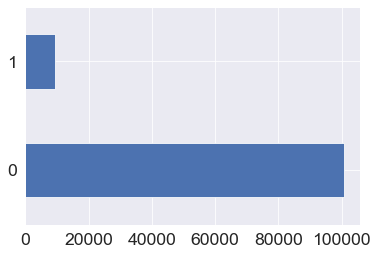

In [179]:
# посмотрим на целевую переменную
data['default'].value_counts().plot.barh()
print(len(data[data['default']==0])/len(data[data['default']==1]))

На графике видно, что клиентов без дефолта больше, чем клиентов с дефолтом почти в 11 раз.

# Предобработка данных¶

In [198]:
# Оценим количество пропусков
data.isna().sum(axis=0)

client_id             0
app_date              0
education           478
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
sample                0
default               0
dtype: int64

Нулевые значения есть только в колонке education. Заменим пустые значения на наиболее часто встречающиеся

In [183]:
data['education'].value_counts(dropna=False)

SCH    58476
GRD    34768
UGR    14748
PGR     1865
ACD      291
Name: education, dtype: int64

In [199]:
data['education'] = data['education'].fillna(data['education'].value_counts().index[0])

<AxesSubplot:>

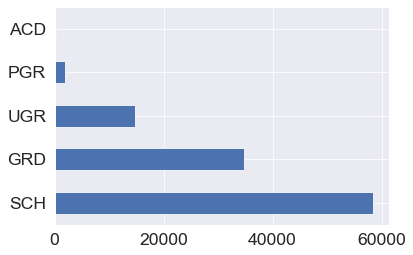

In [185]:
data['education'].value_counts().plot.barh()

In [186]:
# кол-во пропусков сейчас
data.education.isna().sum(axis=0)

0

In [200]:
# Для более удобной работы создадим списки по категориям датасета (категориальные, бинарные, количественные)

num_cols = [
    'age', 
    'decline_app_cnt', 
    'score_bki',
    'income', 
    'bki_request_cnt'
]

cat_cols = [
    'education', 
    'work_address', 
    'home_address', 
    'region_rating',
    'sna', 
    'first_time'
]

bin_cols = [
    'sex', 
    'car', 
    'car_type', 
    'good_work', 
    'foreign_passport'
]

# Количественные признаки

Text(0.5, 1.0, 'income')

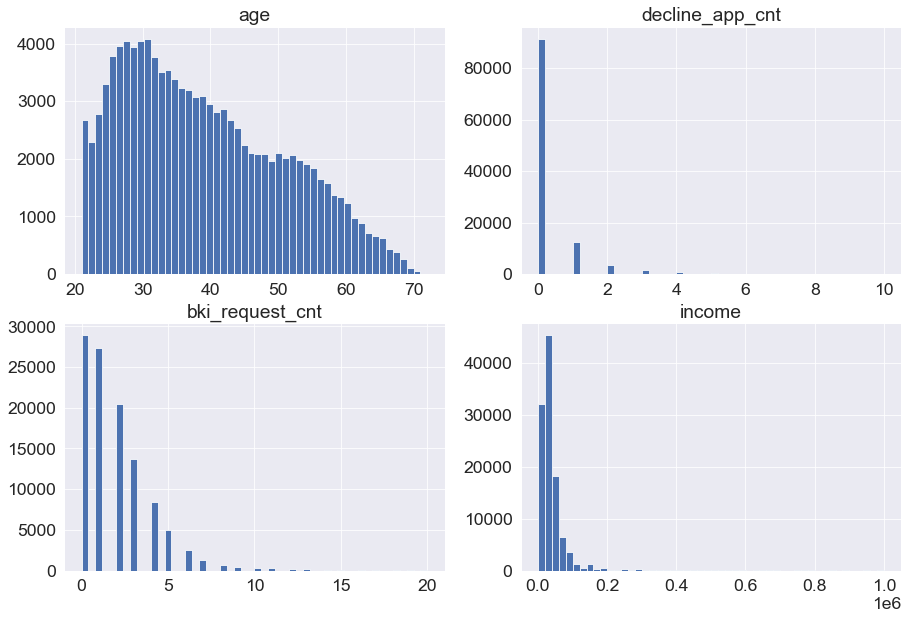

In [193]:
fig, axes = plt.subplots(2, 2, figsize=(15,10))

axes[0,0].hist(data['age'], bins = 50)
axes[0,0].set_title("age")

axes[0,1].hist(data['decline_app_cnt'], bins = 50, range=(0,10))
axes[0,1].set_title("decline_app_cnt")

axes[1,0].hist(data['bki_request_cnt'], bins = 50,  range=(0,20))
axes[1,0].set_title("bki_request_cnt")

axes[1,1].hist(data['income'], bins = 50)
axes[1,1].set_title("income")

По гистограммам можно сделать вывод, что распределения не являются нормальными и смещены вправо. При построении модели необходимо будет выполнить стандартизацию численных признаков.

### Выбросы

In [194]:
# Оценим численные признаки на наличие выбросов
for col in num_cols:
    median = data[col].median()
    IQR = data[col].quantile(0.75) - data[col].quantile(0.25)
    perc25 = data[col].quantile(0.25)
    perc75 = data[col].quantile(0.75)
    
    print("Column: ", col)
    print("Максимальное значение в данных:", data[col].max())
    print("Минимальное значение в данных:", data[col].min())
    print('25%: {},'.format(perc25), '75%: {},'.format(perc75),
          "IQR: {}, ".format(IQR), "Borderline: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))
    print()

Column:  age
Максимальное значение в данных: 72
Минимальное значение в данных: 21
25%: 30.0, 75%: 48.0, IQR: 18.0,  Borderline: [3.0, 75.0].

Column:  decline_app_cnt
Максимальное значение в данных: 33
Минимальное значение в данных: 0
25%: 0.0, 75%: 0.0, IQR: 0.0,  Borderline: [0.0, 0.0].

Column:  score_bki
Максимальное значение в данных: 0.19977285
Минимальное значение в данных: -3.62458632
25%: -2.2604336700000003, 75%: -1.5678881525, IQR: 0.6925455175000004,  Borderline: [-3.299251946250001, -0.5290698762499992].

Column:  income
Максимальное значение в данных: 1000000
Минимальное значение в данных: 1000
25%: 20000.0, 75%: 48000.0, IQR: 28000.0,  Borderline: [-22000.0, 90000.0].

Column:  bki_request_cnt
Максимальное значение в данных: 53
Минимальное значение в данных: 0
25%: 0.0, 75%: 3.0, IQR: 3.0,  Borderline: [-4.5, 7.5].

Column:  app_date
Максимальное значение в данных: 119
Минимальное значение в данных: 0
25%: 33.0, 75%: 89.0, IQR: 56.0,  Borderline: [-51.0, 173.0].



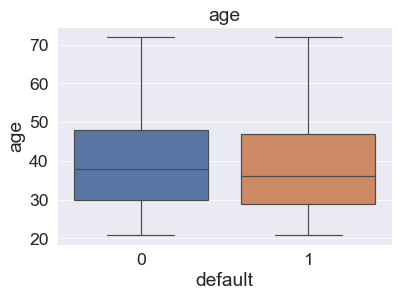

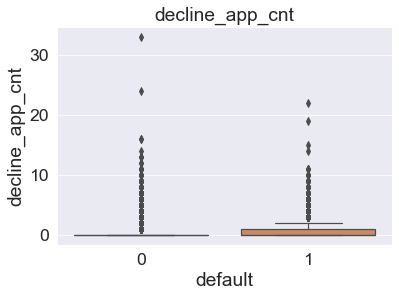

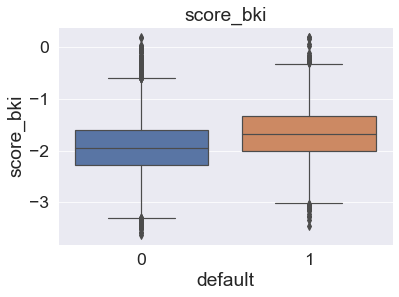

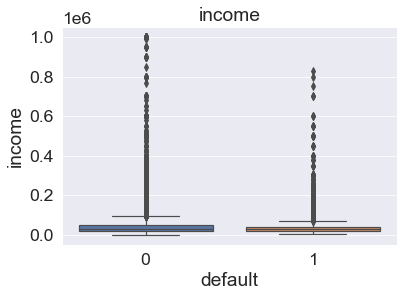

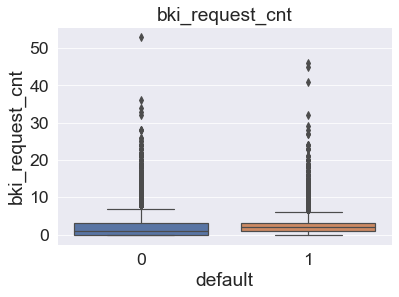

In [201]:
# Посмотрим на графики распределения целевой переменной между количественными признаками
for i in num_cols:
    plt.figure()
    sns.boxplot(x="default", y=i, data=train)
    plt.title(i)
    plt.show()

Можно сказать, что выбросы наблюдаются во всех колонках, кроме age.

Но нужно учесть некоторые моменты: 
1) большинство отказанных заявок (около 85%) являлись дефолтными, и удалять эти данные было бы неправильным
2) доход у 96,2% людей был не более 100 тыс., но также есть люди, у которых он намного больше, поэтому их надо учитывать
3) такая же ситуация и с количеством обращений
Значит, данные удалять не будем.

# Бинарные признаки

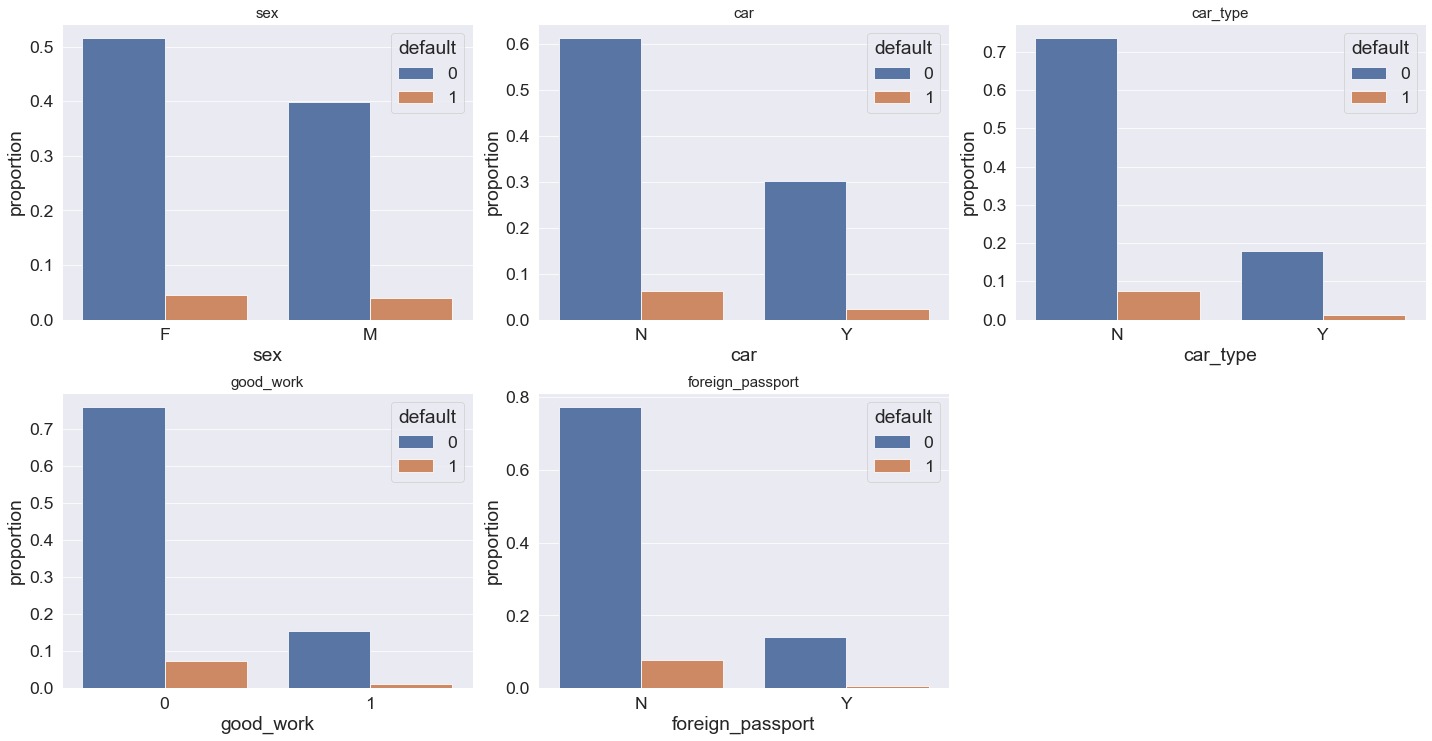

In [203]:
# посмотрим на распределение дефолтных состояний по различным признакам

plt.figure(figsize=[20, 20])
i = 1

for k in bin_cols:
    plt.subplot(4, 3, i)
    sns.barplot(
        x=k,
        y='proportion',
        hue='default',
        data=data[[k, 'default']].value_counts(normalize=True).rename('proportion').reset_index()
    )
    plt.title(k, fontsize=15)
    i += 1
plt.tight_layout()
plt.show()

По графикам можно сделать следующие выводы:

* Женщины чаще берут кредиты, чем мужчины; но пол не влияет на количество дефолтов.
* Заемщики, у которых есть машина, более надежны. Также те, у кого иностранный автомобиль, имеют меньше дефолтов.
* Люди с хорошей работой и заграничным паспортом возвращают долг чаще, чем противоположные группы.

# Категориальные признаки

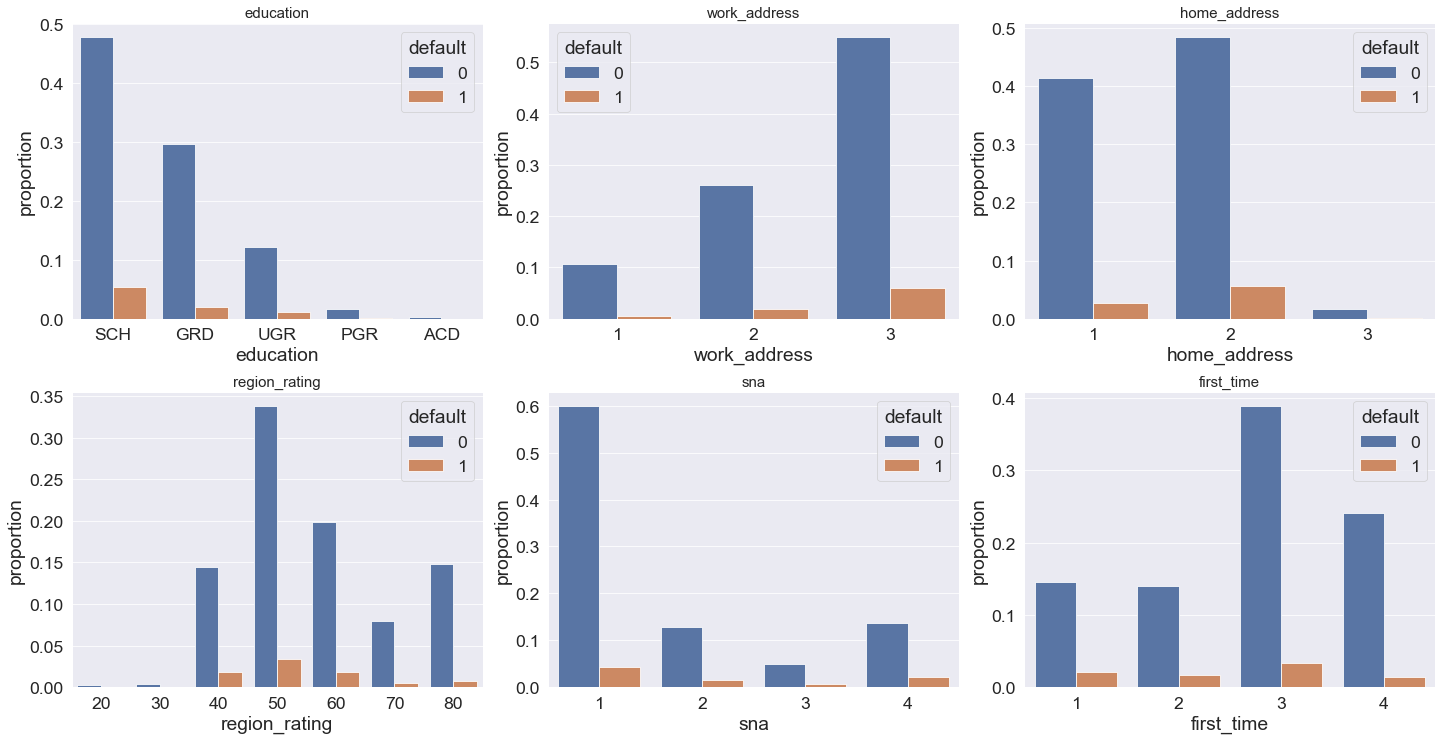

In [208]:
# посмотрим на распределение дефолтов состояний по различным признакам

plt.figure(figsize=[20, 20])
i = 1

for k in cat_cols:
    plt.subplot(4, 3, i)
    sns.barplot(
        x=k, 
        y='proportion', 
        hue='default',  
        data=data[[k, 'default']].value_counts(normalize=True).rename('proportion').reset_index()
    )
    plt.title(k, fontsize=15)
    i += 1
plt.tight_layout()
plt.show()

Клиенты с более низким уровнем образования чаще подвержены дефолту. В то же время, они чаще берут кредиты.
Чем ниже рейтинг региона, тем чаще возникает дефолт по кредитам. Параметр sna: ниже категория - меньше дефолтов. First_time - аналогично.

### Оценка корреляции

<AxesSubplot:>

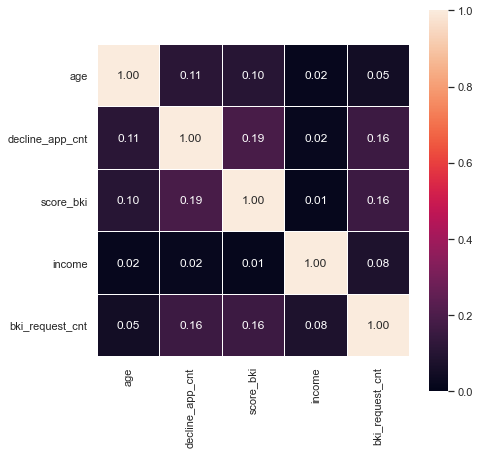

In [209]:
# Посмотрим матрицу корреляций численных признаков
sns.set(font_scale = 1)
fig, axis = plt.subplots(figsize=(7,7))
sns.heatmap(data[num_cols].corr().abs(), vmin=0, vmax=1, square=True,
           annot=True, fmt=".2f", linewidths=0.1)

Здесь видно, что признаки между собой скореллированы слабо, поэтому оставим их для модели.

## Оценка значимости численных признаков

<AxesSubplot:>

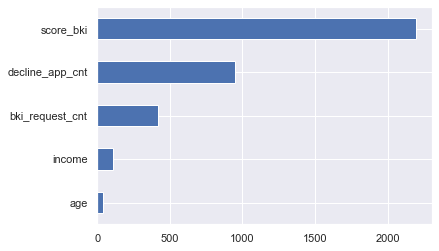

In [210]:
imp_num = pd.Series(f_classif(data[num_cols], data['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

Одним из самых значимых числовых признаков является скоринговый балл по данным из БКИ (score_bki)  

## Оценка значимости бинарных и категориальных признаков

In [218]:
# Для бинарных признаков мы будем использовать LabelEncoder

label_encoder = LabelEncoder()

for column in bin_cols:
    data[column] = label_encoder.fit_transform(data[column])
    
data['education'] = label_encoder.fit_transform(data['education'])

<AxesSubplot:>

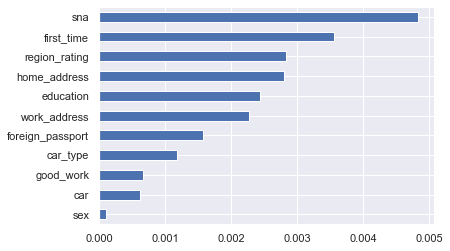

In [219]:
imp_cat = Series(mutual_info_classif(data[bin_cols + cat_cols], data['default'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

Исходя из данных графиков можно сделать вывод о малозначимости признака sex и age. Наиболее значимыми признаками оказались sna и first_time.

# Feature Engineering

In [220]:
# Признак app_date переведем сначала в формат даты, а затем преобразуем 
# признак в "количество дней", чтобы перевести в категрию "численных"
data['app_date'] = pd.to_datetime(data.app_date)
data['app_date'] = data['app_date'].apply(lambda x: (x - data['app_date'].min()).days) # days from the first date
num_cols.append('app_date')

In [221]:
# Переведем колонки region_rating, first_time и home_address из категориальных в численные,
# т.к. при их стандартизации значение метрики roc-auc получается выше, чем при создании из
# них dummy-переменных
cat_cols.remove('region_rating')
num_cols.append('region_rating')

cat_cols.remove('first_time')
num_cols.append('first_time')

cat_cols.remove('home_address')
num_cols.append('home_address')

# Подготовка данных к машинному обучению

In [222]:
# Преобразуем категориальные признаки с помощью get_dummies
data = pd.get_dummies(data, columns=cat_cols)

In [223]:
# выполним стандартизацию численных переменных
data[num_cols] = pd.DataFrame(StandardScaler().fit_transform(data[num_cols]),
                              columns=num_cols)

In [224]:
# Разделим обратно на train и test
train = data.query('sample == 1').drop(['sample'], axis=1)
test = data.query('sample == 0').drop(['sample'], axis=1)

In [225]:
# удалим для X целевую переменную и client_id
X = train.drop(columns = ['default', 'client_id'])
Y = train['default']

In [226]:
# Разделим выборку на train и test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=RANDOM_SEED,
                                                    test_size=0.2)

### Логистическая регрессия

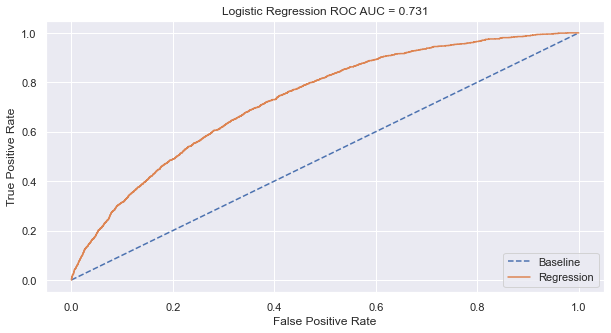

In [227]:
# Построим модель логистической регресии с параметрами "по умолчанию"
model = LogisticRegression()
model.fit(X_train, Y_train)
probs = model.predict_proba(X_test)
y_pred = model.predict(X_test)
probs = probs[:,1]

fpr, tpr, threshold = roc_curve(Y_test, probs)
roc_auc = roc_auc_score(Y_test, probs)

fig, ax = plt.subplots(figsize=(10,5))
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
ax.set_title('Logistic Regression ROC AUC = %0.3f'%roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')

In [229]:
print('accuracy_score: {}'.format(np.round(accuracy_score(Y_test, y_pred), 3)))
print('f1_score: {}'.format(np.round(f1_score(Y_test, y_pred), 3)))
print('recall_score: {}'.format(np.round(recall_score(Y_test, y_pred), 3)))
print('MSE: {}'.format(np.round(mean_squared_error(Y_test, y_pred), 3)))

accuracy_score: 0.874
f1_score: 0.059
recall_score: 0.031
MSE: 0.126


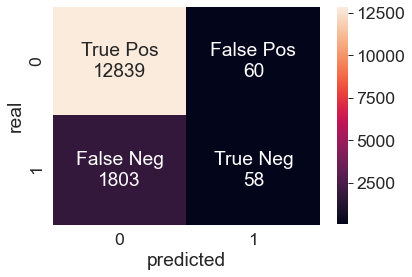

In [230]:
# Confusion matrix:
sns.set_context(context='paper', font_scale=2, rc=None)
group_names = ['True Pos', 'False Pos', 'False Neg', 'True Neg']
group_counts = ['{0:0.0f}'.format(value) for value in
                confusion_matrix(Y_test, y_pred).flatten()]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_names, group_counts)]
labels = np.asarray(labels).reshape(2, 2)
ax = sns.heatmap(confusion_matrix(Y_test, y_pred), annot=labels, fmt='')
ax.set(xlabel='predicted', ylabel='real')
plt.show()

Модель имеет достаточно высокую точность, однако, оценив матрицу ошибок, можно сделать вывод, что почти во всех случаях, когда клиент не способен выплатить кредит, модель все равно его предложит. Найдем оптимальные гиперпараметры.

### Гиперпараметры

Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   24.8s finished


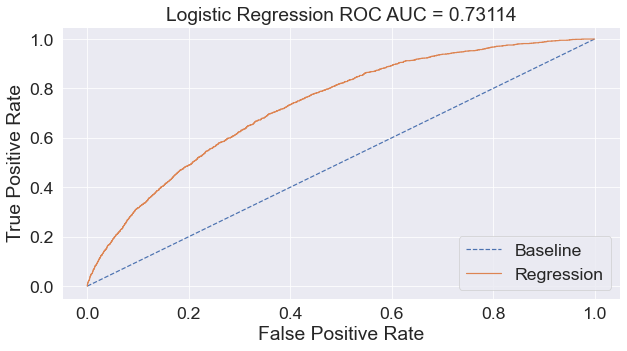

In [231]:
# С помощью GridSearchCV найдем оптимальные параметры
lr_best = LogisticRegression(class_weight='balanced',
                            random_state=RANDOM_SEED)

params = {'C': np.linspace(0, 100, 5),
         'max_iter': np.linspace(start=1,stop=1000,num=10, dtype=int)}

model_best = GridSearchCV(lr_best, param_grid=params, verbose=1, cv=2)

model_best.fit(X_train, Y_train)
probs = model_best.predict_proba(X_test)
y_pred = model_best.predict(X_test)
probs = probs[:,1]

fpr, tpr, threshold = roc_curve(Y_test, probs)
roc_auc = roc_auc_score(Y_test, probs)

fig, ax = plt.subplots(figsize=(10,5))
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
ax.set_title('Logistic Regression ROC AUC = %0.5f'%roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')

In [232]:
print('accuracy_score: {}'.format(np.round(accuracy_score(Y_test, y_pred), 3)))
print('f1_score: {}'.format(np.round(f1_score(Y_test, y_pred), 3)))
print('recall_score: {}'.format(np.round(recall_score(Y_test, y_pred), 3)))
print('MSE: {}'.format(np.round(mean_squared_error(Y_test, y_pred), 3)))


accuracy_score: 0.672
f1_score: 0.335
recall_score: 0.655
MSE: 0.328


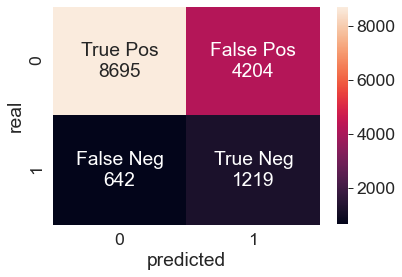

In [233]:
# Confusion matrix:
sns.set_context(context='paper', font_scale=2, rc=None)
group_names = ['True Pos', 'False Pos', 'False Neg', 'True Neg']
group_counts = ['{0:0.0f}'.format(value) for value in
                confusion_matrix(Y_test, y_pred).flatten()]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_names, group_counts)]
labels = np.asarray(labels).reshape(2, 2)
ax = sns.heatmap(confusion_matrix(Y_test, y_pred), annot=labels, fmt='')
ax.set(xlabel='predicted', ylabel='real')
plt.show()

Эта модель много раз ошибается и не выдает кредит клиентам, которые его могли бы выплатить (точность очень понизилась).

### Логистическая регрессия (undersampling)

Так как в исходном датасете данные несбалансированы, попробуем выполнить undersampling, то есть случайным образом уменьшить преобладающий класс

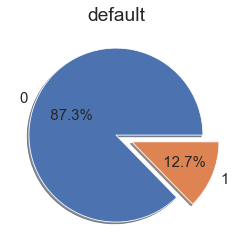

Класс 0 преобладает над классом 1 в 6.9 раз


In [234]:
plt.pie(x=train['default'].value_counts(),
       labels=list(train['default'].value_counts().index),
       autopct='%6.1f%%',
       explode=[0, 0.2],
       shadow=True,
       textprops={'fontsize': 15})
plt.title('default')
plt.show()

print('Класс 0 преобладает над классом 1 в {} раз'.format(
    round(train['default'].value_counts()[0]/train['default'].value_counts()[1],1)))

In [235]:
under_train = pd.concat([train[train['default']==0].sample(
    len(train[train['default']==1]), random_state=RANDOM_SEED), train[train['default']==1]])

X = under_train.drop(columns = ['default', 'client_id'])
Y = under_train['default']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state = RANDOM_SEED,
                                                    test_size=0.2)

Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   10.7s finished


Лучшие параметры модели:  {'C': 100.0, 'max_iter': 56}


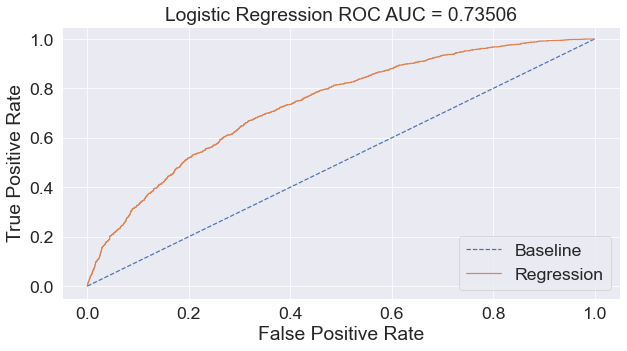

In [236]:
# С помощью GridSearchCV найдем оптимальные параметры
lr_best = LogisticRegression(class_weight='balanced',
                            random_state=RANDOM_SEED)

params = {'C': np.linspace(0, 100, 5),
         'max_iter': np.linspace(start=1,stop=500,num=10, dtype=int)}

model_best = GridSearchCV(lr_best, param_grid=params, verbose=1, cv=2)

model_best.fit(X_train, Y_train)
probs = model_best.predict_proba(X_test)
y_pred = model_best.predict(X_test)
probs = probs[:,1]

fpr, tpr, threshold = roc_curve(Y_test, probs)
roc_auc = roc_auc_score(Y_test, probs)

fig, ax = plt.subplots(figsize=(10,5))
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
ax.set_title('Logistic Regression ROC AUC = %0.5f'%roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')

print("Лучшие параметры модели: ", model_best.best_params_)

In [237]:
print('accuracy_score: {}'.format(np.round(accuracy_score(Y_test, y_pred), 3)))
print('f1_score: {}'.format(np.round(f1_score(Y_test, y_pred), 3)))
print('recall_score: {}'.format(np.round(recall_score(Y_test, y_pred), 3)))
print('MSE: {}'.format(np.round(mean_squared_error(Y_test, y_pred), 3)))

accuracy_score: 0.674
f1_score: 0.68
recall_score: 0.678
MSE: 0.326


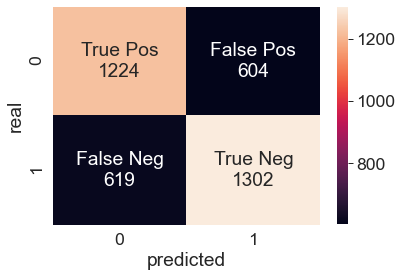

In [238]:
# Confusion matrix:
sns.set_context(context='paper', font_scale=2, rc=None)
group_names = ['True Pos', 'False Pos', 'False Neg', 'True Neg']
group_counts = ['{0:0.0f}'.format(value) for value in
                confusion_matrix(Y_test, y_pred).flatten()]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_names, group_counts)]
labels = np.asarray(labels).reshape(2, 2)
ax = sns.heatmap(confusion_matrix(Y_test, y_pred), annot=labels, fmt='')
ax.set(xlabel='predicted', ylabel='real')
plt.show()


После проведения undersampling модель стала лучше предсказывать класс TrueNegative. Можно попробовать более сложную модель

### CatBoost

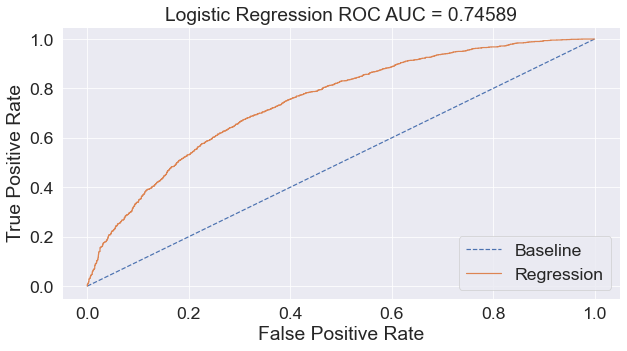

In [239]:
cat = CatBoostClassifier(n_estimators=1000,
                         depth=2,
                         logging_level='Silent')

cat.fit(X_train, Y_train)
probs = cat.predict_proba(X_test)
y_pred = cat.predict(X_test)
probs = probs[:,1]

fpr, tpr, threshold = roc_curve(Y_test, probs)
roc_auc = roc_auc_score(Y_test, probs)

fig, ax = plt.subplots(figsize=(10,5))
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
ax.set_title('Logistic Regression ROC AUC = %0.5f'%roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')

In [240]:
print('accuracy_score: {}'.format(np.round(accuracy_score(Y_test, y_pred), 3)))
print('f1_score: {}'.format(np.round(f1_score(Y_test, y_pred), 3)))
print('recall_score: {}'.format(np.round(recall_score(Y_test, y_pred), 3)))
print('MSE: {}'.format(np.round(mean_squared_error(Y_test, y_pred), 3)))

accuracy_score: 0.681
f1_score: 0.689
recall_score: 0.688
MSE: 0.319


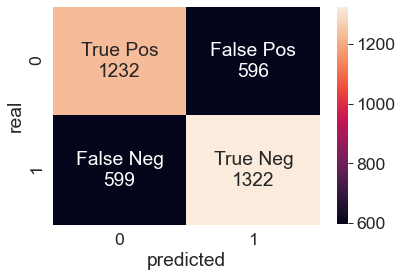

In [241]:
sns.set_context(context='paper', font_scale=2, rc=None)
group_names = ['True Pos', 'False Pos', 'False Neg', 'True Neg']
group_counts = ['{0:0.0f}'.format(value) for value in
                confusion_matrix(Y_test, y_pred).flatten()]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_names, group_counts)]
labels = np.asarray(labels).reshape(2, 2)
ax = sns.heatmap(confusion_matrix(Y_test, y_pred), annot=labels, fmt='')
ax.set(xlabel='predicted', ylabel='real')
plt.show()

Результаты стали значительно лучше, поэтому для будет использована модель CatBoostingClassifier

In [242]:
X_test2 = test.drop(columns = ['default', 'client_id'])
y_probs = cat.predict_proba(X_test2)[:,1]

In [243]:
test['default'] = y_probs

In [244]:
submission = test[['client_id','default']]
display(submission.sample(10))
display(submission.shape)

,client_id,default
27713,54194,0.159216
29963,61353,0.250447
30312,38027,0.316608
12992,42744,0.756716
30891,102055,0.423712
16926,59745,0.131677
23419,75613,0.449761
27503,18839,0.621887
14087,51498,0.803583
30884,86405,0.426597


(36349, 2)

In [245]:
submission.to_csv('submission.csv', index=False)